## 0. before work

```
you must run ../data_prepare/data_prepare.ipynb to create rec dataset firstly
and then run this train file
```

## 1. import package and set global var

In [4]:
import mxnet as mx
from mxnet import gluon, image, autograd, nd
from mxnet.gluon import nn
from mxnet.contrib.ndarray import MultiBoxPrior, MultiBoxTarget
from mxnet import metric

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import time

import sys
sys.path.append("../")
from utils.utils import show_9_images, show_images, mkdir_if_not_exist

# dataset root dir
coins_root = "../dataset/"
sdl_root = coins_root + "sdl-coins/"
swiss_root = coins_root + "swiss-coins/"

data_shape = (3, 800, 600)
batch_size = 8
#mean = np.array([ 167.02477919,  157.20263027,  140.25492473])
#std = np.array([ 46.06696734,  47.12624331,  50.81295717])
rgb_mean = np.array([123, 117, 104])

ctx = mx.gpu(1)

## 2. load data and plot data
```
ImageDetIter will call CreateDetAugmenter
if mean==True, it will sub defualt mean
if std==True, it will div default std

both mean and std can not set to False.

or you can cal them and set them as np.array([r, g, b])
```

In [5]:
def get_iterators(rec_prefix, data_shape, batch_size):
    class_names = ['1yuan', '0.5yuan']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size=batch_size, 
        data_shape=data_shape,
        path_imgrec=rec_prefix + '_train.rec',
        path_imgidx=rec_prefix + '_train.idx',
        shuffle=True,
        mean=True,
        #std=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200)
    
    valid_iter = image.ImageDetIter(
        batch_size=batch_size, 
        data_shape=data_shape,
        path_imgrec=rec_prefix+'_val.rec',
        shuffle=False,
        mean=True,
        #std=True
    )
    
    return train_iter, valid_iter, class_names, num_class

train_data, valid_data, class_names, num_class = get_iterators(sdl_root+"rec/sdl", data_shape, batch_size)
    

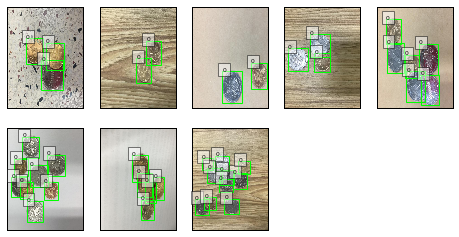

(8L, 14L, 5L)


In [6]:
"""
data plot
"""
mpl.rcParams['figure.dpi'] = 120

train_data.reset()
batch = train_data.next()
images = batch.data[0][:8]
labels = batch.label[0][:8]
show_images(images.asnumpy(), labels.asnumpy(), rgb_mean, show_text=True, fontsize=6)
#show_9_images(images.asnumpy(), labels, rgb_mean)
print labels.shape

## 3.

In [7]:
"""
model define
"""

def down_sample(num_filter):
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filter, kernel_size=3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filter))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

def class_predictor(num_class, num_anchors):
    return nn.Conv2D(num_anchors * (num_class + 1), kernel_size=3, strides=1, padding=1)

def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, strides=1, padding=1)

class SSD(nn.HybridBlock):
    def __init__(self, num_class, sizes_list, ratios_list, verbose=False, **kwargs):
        super(SSD, self).__init__(**kwargs)
        self.num_class = num_class
        self.sizes_list = sizes_list
        self.ratios_list = ratios_list
        self.num_anchors = num_anchors = (len(sizes_list[0]) + len(ratios_list[0]) - 1)
        self.verbose = verbose
        
        with self.name_scope():
            # part 1
            self.body = nn.HybridSequential()
            for filters in [16, 32, 64]:
                self.body.add(down_sample(filters))

            # part 2
            self.downsamples = nn.HybridSequential()
            for _ in range(3):
                self.downsamples.add(down_sample(128))

            # part 3
            self.class_predictors = nn.HybridSequential()
            self.box_predictors = nn.HybridSequential()
            for _ in range(5):
                self.class_predictors.add(class_predictor(num_class, num_anchors))
                self.box_predictors.add(box_predictor(num_anchors))
            
    def hybrid_forward(self, F, x):
        x = self.body(x)
        cls_preds = []
        box_preds = []
        anchors = []
        for i in range(5):
            cls_preds.append((self.class_predictors[i](x)).transpose((0, 2, 3, 1)).flatten())
            box_preds.append((self.box_predictors[i](x)).transpose((0, 2, 3, 1)).flatten())
            anchors.append(MultiBoxPrior(x, sizes=self.sizes_list[i], ratios=self.ratios_list[i]))

            if self.verbose:
                print "predict scale", i, x.shape, 'with', anchors[-1].shape, 'anchors'

            if i < 3:
                x = self.downsamples[i](x)
            elif i == 3:
                x = F.Pooling(x, global_pool=True, pool_type='max', kernel=(x.shape[2], x.shape[3]))
        cls_preds = nd.concat(*cls_preds, dim=1).reshape((0, -1, num_class+1))
        box_preds = nd.concat(*box_preds, dim=1)
        anchors = nd.concat(*anchors, dim=1)
        return anchors, box_preds, cls_preds


In [8]:
sizes_list = [[.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
ratios_list = [[1, 2, .5]]*5
net = SSD(2, sizes_list, ratios_list, verbose=True, prefix="ssd_")
net.initialize()
anchors, box_preds, cls_preds = net(batch.data[0])
box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, batch.label[0], cls_preds.transpose(axes=(0, 2, 1)))
print cls_labels.shape, cls_preds.shape, box_offset.shape, box_mask.shape

predict scale 0 (8L, 64L, 100L, 75L) with (1L, 30000L, 4L) anchors
predict scale 1 (8L, 128L, 50L, 37L) with (1L, 7400L, 4L) anchors
predict scale 2 (8L, 128L, 25L, 18L) with (1L, 1800L, 4L) anchors
predict scale 3 (8L, 128L, 12L, 9L) with (1L, 432L, 4L) anchors
predict scale 4 (8L, 128L, 1L, 1L) with (1L, 4L, 4L) anchors
(8L, 39636L) (8L, 39636L, 3L) (8L, 158544L) (8L, 158544L)


In [ ]:
"""
loss define
"""
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gama=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self.alpha = alpha
        self.gama = gama
        self.axis = axis
        self.batch_axis = batch_axis
        
    def hybrid_forward(self, F, y, label):
        y = F.softmax(y)
        py = y.pick(label, axis=self.axis, keepdims=True)
        loss = - (self.alpha * ((1 - py) ** self.gama)) * py.log()
        return loss.mean(axis=self.batch_axis, exclude=True)
    
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)
        self.batch_axis = batch_axis
        
    def hybrid_forward(self, F, y, label, mask):
        loss = F.smooth_l1((y - label) * mask, scalar=1.0)
        return loss.mean(axis=self.batch_axis, exclude=True)
    
cls_loss = FocalLoss()
box_loss = SmoothL1Loss()

In [ ]:
"""
train net
"""

def evaluate_acc(data_iter):
    data_iter.reset()
    cls_metric = metric.Accuracy()
    box_metric = metric.MAE()
    for i, batch in enumerate(data_iter):
        data = batch.data[0].as_in_context(ctx)
        label = batch.label[0].as_in_context(ctx)
        anchors, box_preds, cls_preds = net(data)
        box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, cls_preds.transpose(axes=(0, 2, 1)))
        cls_metric.update([cls_labels], [cls_preds.transpose((0, 2, 1))])
        box_metric.update([box_offset], [box_preds * box_mask])
    return cls_metric, box_metric
        

def train(net, start_epoch, end_epoch, trainer=None):
    if trainer is None:
        trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})
    cls_metric = metric.Accuracy()
    box_metric = metric.MAE()
    
    for e in range(start_epoch, end_epoch):
        train_data.reset()
        cls_metric.reset()
        box_metric.reset()
        tic = time.time()
        if (e + 1) % 40 == 0:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
        for i, batch in enumerate(train_data):
            data = batch.data[0].as_in_context(ctx)
            label = batch.label[0].as_in_context(ctx)
            with autograd.record():
                anchors, box_preds, cls_preds = net(data)
                box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, cls_preds.transpose(axes=(0, 2, 1)), 
                                                                  overlap_threshold=0.75, negative_mining_ratio=3.0)
                loss1 = cls_loss(cls_preds, cls_labels)
                loss2 = box_loss(box_preds, box_offset, box_mask)
                loss = loss1 + loss2
            loss.backward()
            trainer.step(data.shape[0])
            
            cls_metric.update([cls_labels], [cls_preds.transpose((0, 2, 1))])  # maybe pick axi=1, so change prob to axi 1  
            box_metric.update([box_offset], [box_preds * box_mask])
            
        val_cls_metric, val_box_metric = evaluate_acc(valid_data)
        print "epoch", e, "train", cls_metric.get(), box_metric.get(), "time", time.time() - tic
        print "        valid", val_cls_metric.get(), val_box_metric.get(), 'lr', trainer.learning_rate

net = SSD(2, sizes_list, ratios_list, verbose=False, prefix="ssd_")
net.initialize(ctx=ctx)
train(net, 0, 100)

epoch 0 train ('accuracy', 4.362616476603761e-05) ('mae', 0.00079120713780866936) time 61.5187160969
        valid ('accuracy', 0.949723735997578) ('mae', 0.010168719367356971) lr 0.1


In [10]:
mkdir_if_not_exist("models")
net.save_params("models/sdl_coin1.param")

## 可视化测试结果

In [12]:
sizes_list = [[.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
ratios_list = [[1, 2, .5]]*5
net = SSD(2, sizes_list, ratios_list, verbose=False, prefix="ssd_")
net.initialize(ctx=ctx)
net.load_params("models/sdl_coin1.param", ctx=ctx)

a, b = evaluate_acc(valid_data)
print a.get(), b.get()

('accuracy', 0.9784949288525583) ('mae', 0.0097360663639847189)


In [26]:
from utils.utils import show_det_result, try_asnumpy, box_to_rect
from mxnet.contrib.ndarray import MultiBoxDetection

def show_det_result(im, out, threshold=0.5, class_names=None, colors = ['blue', 'green', 'red', 'black', 'magenta']):
    """
    im: image data, numpy.array or ndarray
    out: detection result, numpy.array or ndarray
    theshold: score threshold
    class_name: class or labels name
    """
    im = try_asnumpy(im)
    out = try_asnumpy(out)
    
    plt.imshow(im)
    for row in out:
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:  # class_id < 0 is background rect
            continue
        if row[2] + row[4] < 0 or row[3] + row[5] < 0:
            continue
        color = colors[class_id%len(colors)]
        box = row[2:6] * np.array([im.shape[1],im.shape[0]]*2)
        rect = box_to_rect(box, color, 2)
        plt.gca().add_patch(rect)
        print row

        text = class_names[class_id] if class_names else "class " + str(class_id)
        plt.gca().text(box[0], box[1],
                       '{:s} {:.2f}'.format(text, score),
                       bbox=dict(facecolor=color, alpha=0.5),
                       fontsize=10, color='white')
    plt.show()

def predict(x):
    anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
    box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, cls_preds.transpose(axes=(0, 2, 1)), overlap_threshold=0.75)
    cls_probs = nd.SoftmaxActivation(
        cls_preds.transpose((0,2,1)), mode='channel')

    return MultiBoxDetection(cls_probs, box_preds, anchors,
                             force_suppress=True, clip=True, nms_threshold=0.45), cls_preds

mpl.rcParams['figure.figsize'] = (6,6)
valid_data.reset()
batch = valid_data.next()
data = batch.data[0].as_in_context(ctx)
label = batch.label[0].as_in_context(ctx)
anchors, box_preds, cls_preds = net(data)
cls_probs = nd.SoftmaxActivation(cls_preds.transpose((0, 2, 1)), mode='channel')
out = MultiBoxDetection(cls_probs, box_preds, anchors, force_suppress=True, clip=False, nms_threshold=0.45)
box_offset, box_mask, cls_labels = MultiBoxTarget(anchors, label, 
                                                  cls_preds.transpose(axes=(0, 2, 1)), overlap_threshold=0.75)

In [36]:
print cls_labels
print nd.mean(cls_labels == cls_preds.argmax(axis=2))
print nd.mean(cls_labels == 0)
print nd.mean(box_mask.reshape((0, -1, 4)).transpose((2, 0, 1)) == (cls_labels>0))  # box_mask is generate from label


[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
<NDArray 8x39636 @gpu(1)>

[ 0.99853671]
<NDArray 1 @gpu(1)>

[ 0.99932194]
<NDArray 1 @gpu(1)>

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
<NDArray 8x39636 @gpu(1)>

[ 1.]
<NDArray 1 @gpu(1)>


[ 0.          0.7115472   0.07672405  0.05377901  1.16192031  0.90570295]
[ 1.          0.61068916  0.28448617 -0.05113474  0.75555801  0.81272626]
[ 1.          0.58457029 -0.28307909  0.17284974  0.43912059  1.09499633]
[ 1.          0.58453488  0.24029338  0.34590665  0.94862139  0.8977145 ]


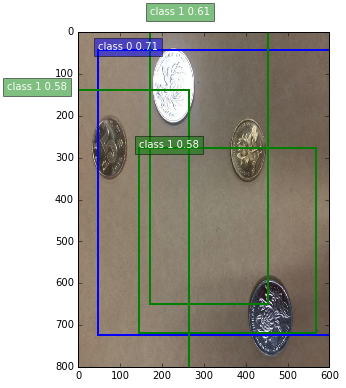

In [14]:
img = data.transpose((0, 2, 3, 1))[0].asnumpy() + rgb_mean
img = img.astype('uint8')
show_det_result(img, out[0], threshold=0.5)

In [24]:
?? MultiBoxTarget